## 1. G4 predict 
### mainly used quadron method to G4 in the all genome，github ： https://github.com/aleksahak/Quadron
#### reference: Sahakyan, A.B., Chambers, V.S., Marsico, G. et al. Machine learning model for sequence-driven DNA G-quadruplex formation. Sci Rep 7, 14535 (2017).
### 1.1  Quadron G4 predict
#### 1.1.1 Distribution of Quadron scores and loci lengths.

In [1]:
%load_ext rpy2.ipython

In [ ]:
import os
def myMkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        print("this path %s is exist!!!" %path)
        
root_path = "/disk2/G4_MS"
G4_path = os.path.join(root_path,"G4_identify")
myMkdir(G4_path)


In [ ]:
%%R 
##  wdpath :/disk2/project/g_quadruplex/G4_identify
## Quadron.R fixed
args <- commandArgs(trailingOnly = TRUE)
print("NOTE: Loading Quadron core...", quote=FALSE)
load("Quadron.lib")
Quadron(FastaFile= args[1], 
        OutFile  = args[2],
        nCPU     = as.numeric(args[3]),
        SeqPartitionBy = 1000000)

#### reference Genome: hg38 download from UCSC database
Run Quadron in bash
```
Rscript Quadron.R chr*.fa.gz chr*.Qiadron.bed 8
```

I ran Quadron for each chromosome separately to speed up the process. The next script merges all the outputs in a BED file.

In [ ]:
# @file G4_deal.py
import re
QuadronBed = open("hs38d2.quadron.bed",'w+')
chroms = ["chr"+str(i) for i in range(1,23)]
chroms.append("chrX")
chroms.append("chrY")
for chrom in chroms:
    QuadronOutPut= open("{}.Quadron.bed".format(chrom),'rt')
    for line in QuadronOutPut:
        array = re.compile("[ ]+").split(line.strip())
        if array[0] == "DATA:":
            postion,strand,length,score,motif = array[1],array[2],array[3],array[4],array[5]
            start=str(int(postion))
            end = str(int(start)+int(length))
            QuadronBed.write(chrom+"\t"+start +"\t" + end +"\t" + motif +"\t" + length +"\t" +strand+"\t"+ score +"\n")

output is **hs38d2.quadron.bed**.
### 1.1.1 Distribution of Quadron scores and loci lengthes.

[1] 19.47


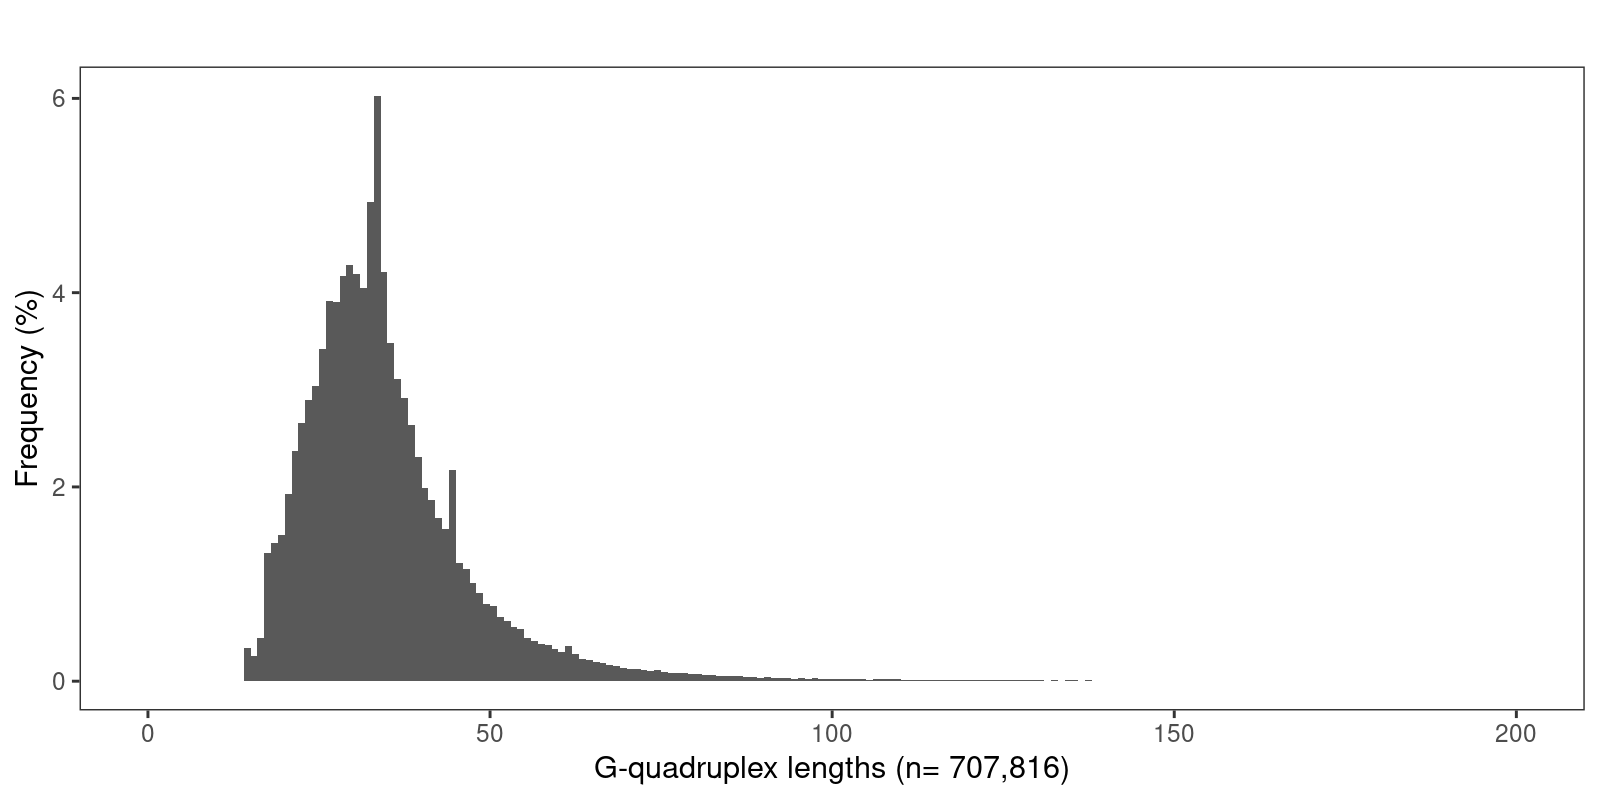

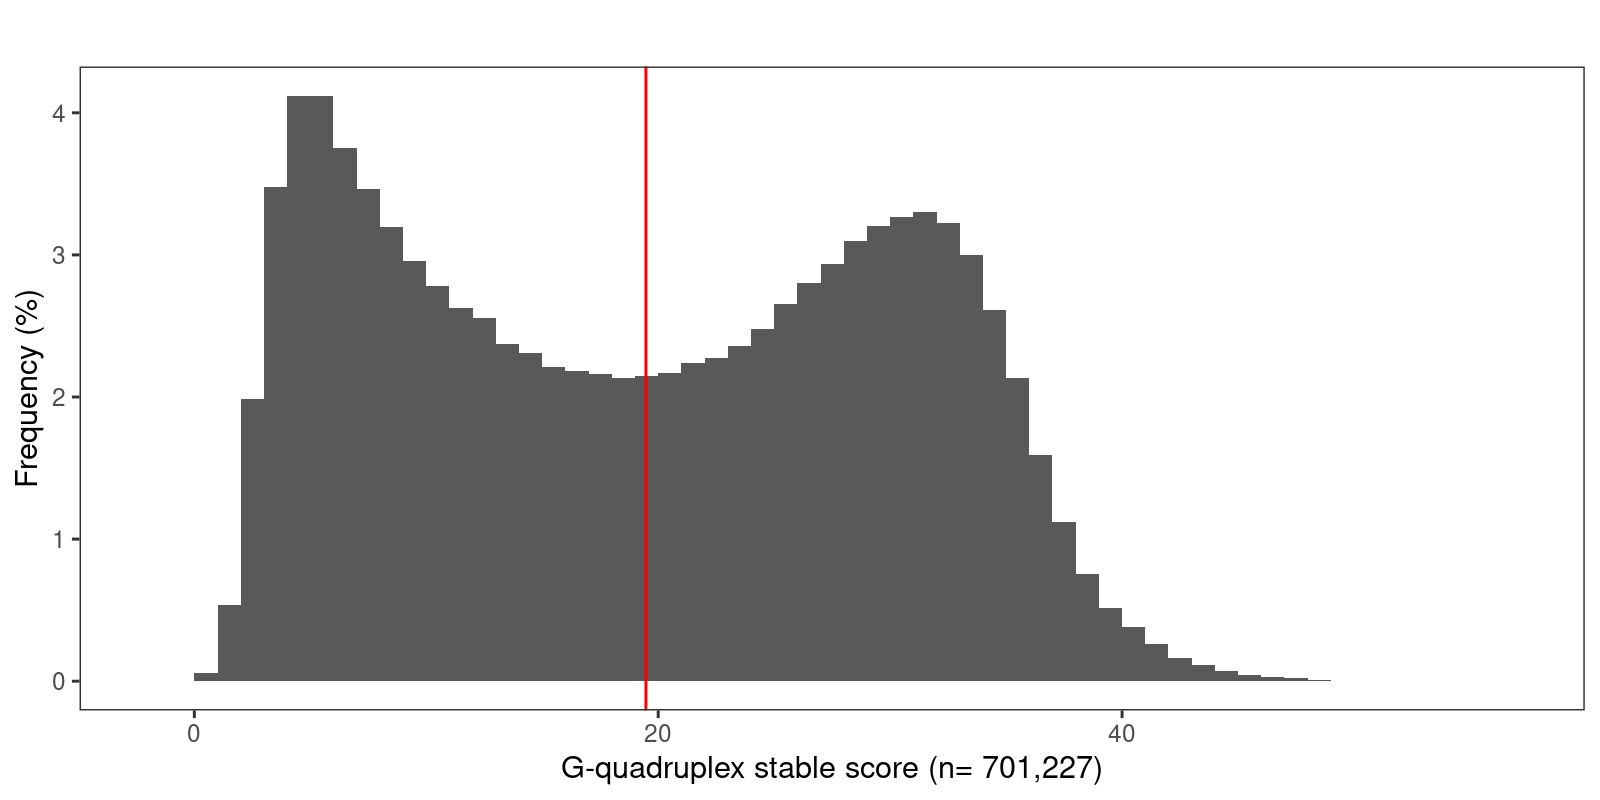

In [5]:
%%R -w 8 -h 4 --units in -r 200
library("ggplot2")
library(grid)
library(gridExtra)
setwd("/disk2/G4_MS/G4_identify/G4_fre")
df <- read.csv("../Quadron/hs38d2.quadron.bed",header=F,sep="\t")
colnames(df) <- c("Chromotain","Start","End","G4","Lengths","Strand","Score")
g1 <- ggplot(data=df,aes(x=Lengths,y=..debsity..))+
    geom_histogram(aes(x=Lengths,y=..density..*100), stat="bin",binwidth=1,boundary=0)+
    xlim(0,200)+labs(title="",y="Frequency (%)",
                     x=paste0("G-quadruplex lengths (","n= ",prettyNum(length(df$Lengths), big.mark=',', trim = TRUE),")"))+
    guides(fill=FALSE) + 
    theme_bw() + theme(panel.grid.major =element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) + 
    theme(legend.position="none")
grid.arrange(g1)
G <- arrangeGrob(g1)
ggsave("pG4_genomic.lengths.distribution.pdf",G,width=9,height=6)

df <- df[which(df$Lengths < 100),]
print(median(df$Score))
g <- ggplot(data=df,aes(x=Score,y=..debsity..))+
    geom_histogram(aes(x=Score,y=..density..*100), stat="bin",binwidth=1,boundary=0)+
#     xlim(0,60)+
    geom_vline(xintercept=median(df$Score),color="red")+
    labs(title="",y="Frequency (%)",
         x=paste0("G-quadruplex stable score (","n= ",prettyNum(length(df$Lengths), big.mark=',', trim = TRUE),")"))+
    guides(fill=FALSE) + 
    theme_bw() + theme(panel.grid.major =element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) + 
    theme(legend.position="none")
grid.arrange(g)
G <- arrangeGrob(g)
ggsave("genomic_G4_stable_score.pdf",G,width=9,height=6)

### 1.2 G4 frequency  within a range of 2 kb near TSS

```
TSS was annotated by GENCODE,which was downloaded at https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz
```
#### We used only transcripts with the basic tag for subsequent analyses: ```grep "basic" gencode.v38.annotation.gtf > gencode.v38.annotation.transcript_basic.gtf```

##### the GPQS (cpG4) means pG4s were in the coding strand for a given gene; the CPQS (tpG4) means that pG4 were in the template strand in a given gene.

In [ ]:
## @g4_pos_fre.get.py
import os,sys
import pandas as pd
import pyranges as pr
from collections import Counter
from typing import Iterable
from itertools import chain
import numpy as np
def flatten(items,ignore_types=(str,bytes)):
    for x in items:
        if isinstance(x,Iterable) and not isinstance(x,ignore_types):
            yield from flatten(x)
        else:
            yield x
def relative_pos_get(df):
    if df["Strand"] == "+":
#         print(df.Satrt-df.Tss_start,df.End-df.Tss_start)
        return np.arange(df["Start"]-df["Tss_start"],df["End"]-df["Tss_start"],1)
    else:
        return np.arange(df["Tss_start"]- df["End"]+1,df["Tss_start"] -df["Start"]+1,1)
real_bed = False
if len(sys.argv) == 3:
    real_bed = True
gtf_path = "/disk2/G4_MS/reference/gencode.v38.annotation.transcript_basic.gtf"
wd_path = sys.argv[1]
if not os.path.exists(wd_path):
    os.mkdir(wd_path)
# wd_path = "/disk2/G4_MS/G4_identify/G4_tss_2kb_fre"
gtf = pr.read_gtf(gtf_path)
s = gtf.Feature == "transcript"
gtf = gtf[s]
gtf = gtf[gtf.gene_type=="protein_coding"]
gtf = gtf.five_end()
gtf.Tss_start = gtf.Start
gtf.Tss_end = gtf.End

# 
gtf = gtf.max_disjoint(slack=50, strand=True)
gtf = gtf.slack(2000)
g4_path = "/disk2/G4_MS/G4_identify/Quadron"
g4 = os.path.join(g4_path,"hs38d2.quadron.bed")
g4 = pr.read_bed(g4)
g4 = g4[g4.Score<100]

if real_bed:
#     real_bed = pr.read_bed("/disk2/project/g_quadruplex/promoter_select/real_chip_seq_G4/all_tissue.bed")
    real_bed = pr.read_bed(sys.argv[2])
    g4 = g4.overlap(real_bed)
gr = gtf.intersect(g4,strandedness=False).as_df()

result = flatten(gr.apply(lambda x:relative_pos_get(x),axis=1))
test = Counter(result)

g4Number = g4.intersect(gtf).drop_duplicate_positions().as_df().shape[0]
with open(os.path.join(wd_path,"all_G4.pos_fre.csv"),'w')as fw:
    fw.write("Distance,counts\n")
    for k in sorted(test.keys()):
        fw.write(str(k)+","+str(test[k]*1.0/g4Number)+"\n")
gpqs = gtf.intersect(g4,strandedness="same").as_df()
gpqs_result = Counter(flatten(gpqs.apply(lambda x:relative_pos_get(x),axis=1)))
# g4Number = 28843
gpqs = pr.PyRanges(gpqs)
g4Number = g4.intersect(gpqs).drop_duplicate_positions().as_df().shape[0]     
with open(os.path.join(wd_path,"GPQS.pos_fre.csv"),'w')as fw:
    fw.write("Distance,gpqs\n")
    for k in sorted(gpqs_result.keys()):
        fw.write(str(k)+","+str(gpqs_result[k]*1.0/g4Number)+"\n")
cpqs = gtf.intersect(g4,strandedness="opposite").as_df()
cpqs_result = Counter(flatten(cpqs.apply(lambda x:relative_pos_get(x),axis=1)))

cpqs = pr.PyRanges(cpqs)
g4Number = g4.intersect(cpqs).drop_duplicate_positions().as_df().shape[0]   
with open(os.path.join(wd_path,"CPQS.pos_fre.csv"),'w')as fw:
    fw.write("Distance,cpqs\n")
    for k in sorted(cpqs_result.keys()):
        fw.write(str(k)+","+str(cpqs_result[k]*1.0/g4Number)+"\n")

In [ ]:
%%bash
cd /disk2/G4_MS/G4_identify/G4_tss_2kb_fre
python g4_pos_fre.get.py /disk2/G4_MS/G4_identify/G4_tss_2kb_fre
paste -d',' GPQS.pos_fre.csv CPQS.pos_fre.csv|cut -d',' -f 1,2,4 > posfre.data.csv

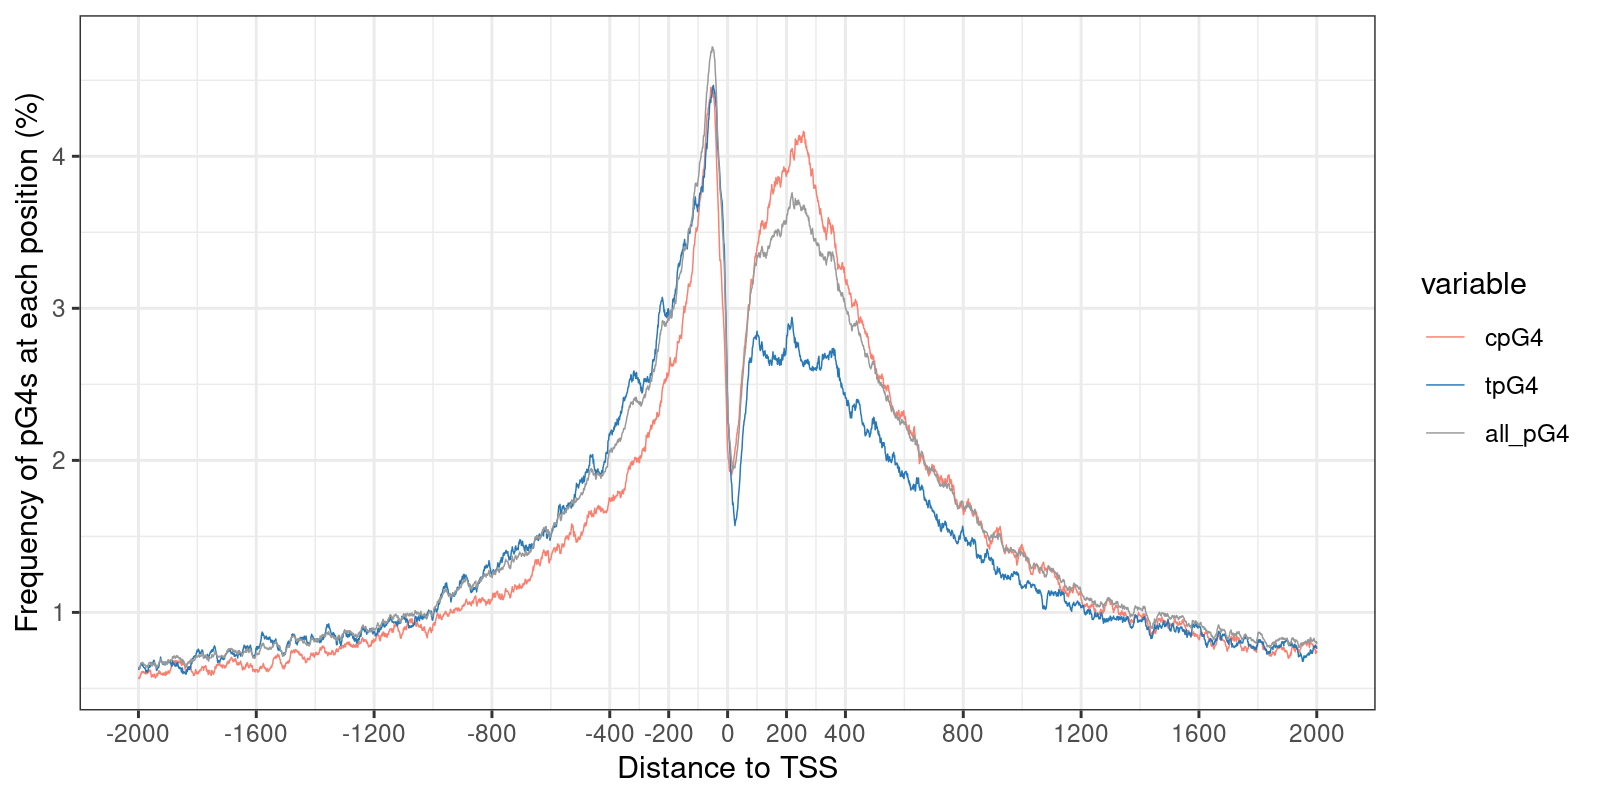

In [8]:
%%R -w 8 -h 4 --units in -r 200
library("ggplot2")
library(grid)
library(gridExtra)
library(dplyr)
# library(ggsci)
library(ggsignif)
library(reshape2)
setwd("/disk2/G4_MS/G4_identify/G4_tss_2kb_fre")

df <- read.csv("posfre.data.csv")
colnames(df) <- c("Distance","cpG4","tpG4")
df_all <- read.csv("all_G4.pos_fre.csv")
df$all_pG4 = df_all$counts
dat <- melt(df,id.vars=c("Distance"))
p1 <- ggplot(data=dat)+geom_line(mapping=aes(x=Distance,y=value*100,color=variable),size=0.25)+ 
    scale_color_manual(values=c("cpG4"="#FA7F6F","tpG4"="#2878b5", "all_pG4"="#999999"))+
    scale_linetype_manual(values=c("solid", "solid","twodash"))

p1 <- p1+labs(x="Distance to TSS",y="Frequency of pG4s at each position (%)")+
    scale_x_continuous(breaks = c(-2000,-1600,-1200,-800,-400,-200,0,200,400,800,1200,1600,2000))+ 
    theme_bw()
grid.arrange(p1)
G <- arrangeGrob(p1)
ggsave("pos_frequency.pdf",width=8,height=4)

#### The data used in the analyses of this study were downloaded from NCBI Gene Expression Omnibus (GEO; https://www.ncbi.nlm.nih.gov/geo/). The list of the used data is as follows.
* BG4 ChIP-seq in K562 cells: GSE107690
* BG4 ChIP-seq in HepG2 cells: GSE145090
* G4P ChIP-seq in A549, H1975 and HEK293T cells: GSE133379
* BG4 CUT&Tag dataset in HEK293T cells: GSE178668

### the distribution of G4 in the upstream and downstream of the Tss was divided *in cellulo* 

In [ ]:
## @g4_pos_fre.get.py
import os,sys
import pandas as pd
import pyranges as pr
from collections import Counter
from typing import Iterable
from itertools import chain
import numpy as np
def flatten(items,ignore_types=(str,bytes)):
    for x in items:
        if isinstance(x,Iterable) and not isinstance(x,ignore_types):
            yield from flatten(x)
        else:
            yield x
def relative_pos_get(df):
    if df["Strand"] == "+":
#         print(df.Satrt-df.Tss_start,df.End-df.Tss_start)
        return np.arange(df["Start"]-df["Tss_start"],df["End"]-df["Tss_start"],1)
    else:
        return np.arange(df["Tss_start"]- df["End"]+1,df["Tss_start"] -df["Start"]+1,1)
real_bed = False
if len(sys.argv) == 3:
    real_bed = True
gtf_path = "/disk2/G4_MS/reference/gencode.v38.annotation.transcript_basic.gtf"
# wd_path = sys.argv[1]
wd_path = "/disk2/G4_MS/G4_identify/real_chip_seq_G4"
if not os.path.exists(wd_path):
    os.mkdir(wd_path)
# wd_path = "/disk2/G4_MS/G4_identify/G4_tss_2kb_fre"
gtf = pr.read_gtf(gtf_path)
s = gtf.Feature == "transcript"
gtf = gtf[s]
gtf = gtf[gtf.gene_type=="protein_coding"]
gtf = gtf.five_end()
gtf.Tss_start = gtf.Start
gtf.Tss_end = gtf.End

# 
gtf = gtf.max_disjoint(slack=50, strand=True)
gtf = gtf.slack(2000)
g4_path = "/disk2/G4_MS/G4_identify/real_chip_seq_G4/A549.overlap.bed"
g4 = pr.read_bed(g4_path)
gr = gtf.intersect(g4,strandedness=False).as_df()

result = flatten(gr.apply(lambda x:relative_pos_get(x),axis=1))
test = Counter(result)

g4Number = g4.intersect(gtf).drop_duplicate_positions().as_df().shape[0]
print(f'A549: {g4Number}')
with open(os.path.join(wd_path,"A549_G4.pos_fre.csv"),'w')as fw:
    fw.write("Distance,counts\n")
    for k in sorted(test.keys()):
        fw.write(str(k)+","+str(test[k]*1.0/g4Number)+"\n")
g4_path = "/disk2/G4_MS/G4_identify/real_chip_seq_G4/H1975.overlap.bed"
g4 = pr.read_bed(g4_path)
gr = gtf.intersect(g4,strandedness=False).as_df()
result = flatten(gr.apply(lambda x:relative_pos_get(x),axis=1))
test = Counter(result)

g4Number = g4.intersect(gtf).drop_duplicate_positions().as_df().shape[0]
print(f'H1975: {g4Number}')
with open(os.path.join(wd_path,"H1975_G4.pos_fre.csv"),'w')as fw:
    fw.write("Distance,counts\n")
    for k in sorted(test.keys()):
        fw.write(str(k)+","+str(test[k]*1.0/g4Number)+"\n")


g4_path = "/disk2/G4_MS/G4_identify/real_chip_seq_G4/293T.overlap.bed"
g4 = pr.read_bed(g4_path)
gr = gtf.intersect(g4,strandedness=False).as_df()
result = flatten(gr.apply(lambda x:relative_pos_get(x),axis=1))
test = Counter(result)

g4Number = g4.intersect(gtf).drop_duplicate_positions().as_df().shape[0]
print(f'HEK293T: {g4Number}')
with open(os.path.join(wd_path,"293T_G4.pos_fre.csv"),'w')as fw:
    fw.write("Distance,counts\n")
    for k in sorted(test.keys()):
        fw.write(str(k)+","+str(test[k]*1.0/g4Number)+"\n")
        

g4_path = "/disk2/G4_MS/G4_identify/real_chip_seq_G4/K562_async_rep1-3.mult.5of8.bed"
g4 = pr.read_bed(g4_path)
gr = gtf.intersect(g4,strandedness=False).as_df()
result = flatten(gr.apply(lambda x:relative_pos_get(x),axis=1))
test = Counter(result)

g4Number = g4.intersect(gtf).drop_duplicate_positions().as_df().shape[0]
print(f'K562: {g4Number}')
with open(os.path.join(wd_path,"K562_G4.pos_fre.csv"),'w')as fw:
    fw.write("Distance,counts\n")
    for k in sorted(test.keys()):
        fw.write(str(k)+","+str(test[k]*1.0/g4Number)+"\n")
        
g4_path = "/disk2/G4_MS/G4_identify/real_chip_seq_G4/HepG2_async_rep1-3.mult.6of9.bed"
g4 = pr.read_bed(g4_path)
gr = gtf.intersect(g4,strandedness=False).as_df()
result = flatten(gr.apply(lambda x:relative_pos_get(x),axis=1))
test = Counter(result)

g4Number = g4.intersect(gtf).drop_duplicate_positions().as_df().shape[0]
print(f'HepG2: {g4Number}')
with open(os.path.join(wd_path,"HepG2_G4.pos_fre.csv"),'w')as fw:
    fw.write("Distance,counts\n")
    for k in sorted(test.keys()):
        fw.write(str(k)+","+str(test[k]*1.0/g4Number)+"\n")

g4_path = "/disk2/G4_MS/G4_identify/real_chip_seq_G4/HEK293T_DMSO_async_rep1-2.mult.2of2.bed"
g4 = pr.read_bed(g4_path)
gr = gtf.intersect(g4,strandedness=False).as_df()
result = flatten(gr.apply(lambda x:relative_pos_get(x),axis=1))
test = Counter(result)

g4Number = g4.intersect(gtf).drop_duplicate_positions().as_df().shape[0]
print(f'HEK293T_cut: {g4Number}')
with open(os.path.join(wd_path,"HEK293T_cut_G4.pos_fre.csv"),'w')as fw:
    fw.write("Distance,counts\n")
    for k in sorted(test.keys()):
        fw.write(str(k)+","+str(test[k]*1.0/g4Number)+"\n")

```
A549: 19713
H1975: 21444
HEK293T: 11299
K562: 8221
HepG2: 5491
HEK293T_cut: 2033
```

In [ ]:
%%bash
cd /disk2/G4_MS/G4_identify/real_chip_seq_G4
paste -d',' A549_G4.pos_fre.csv H1975_G4.pos_fre.csv 293T_G4.pos_fre.csv 
K562_G4.pos_fre.csv HepG2_G4.pos_fre.csv HEK293T_cut_G4.pos_fre.csv|cut -d',' -f 1,2,4,6,8,10,12 > realData_posfre.data.csv

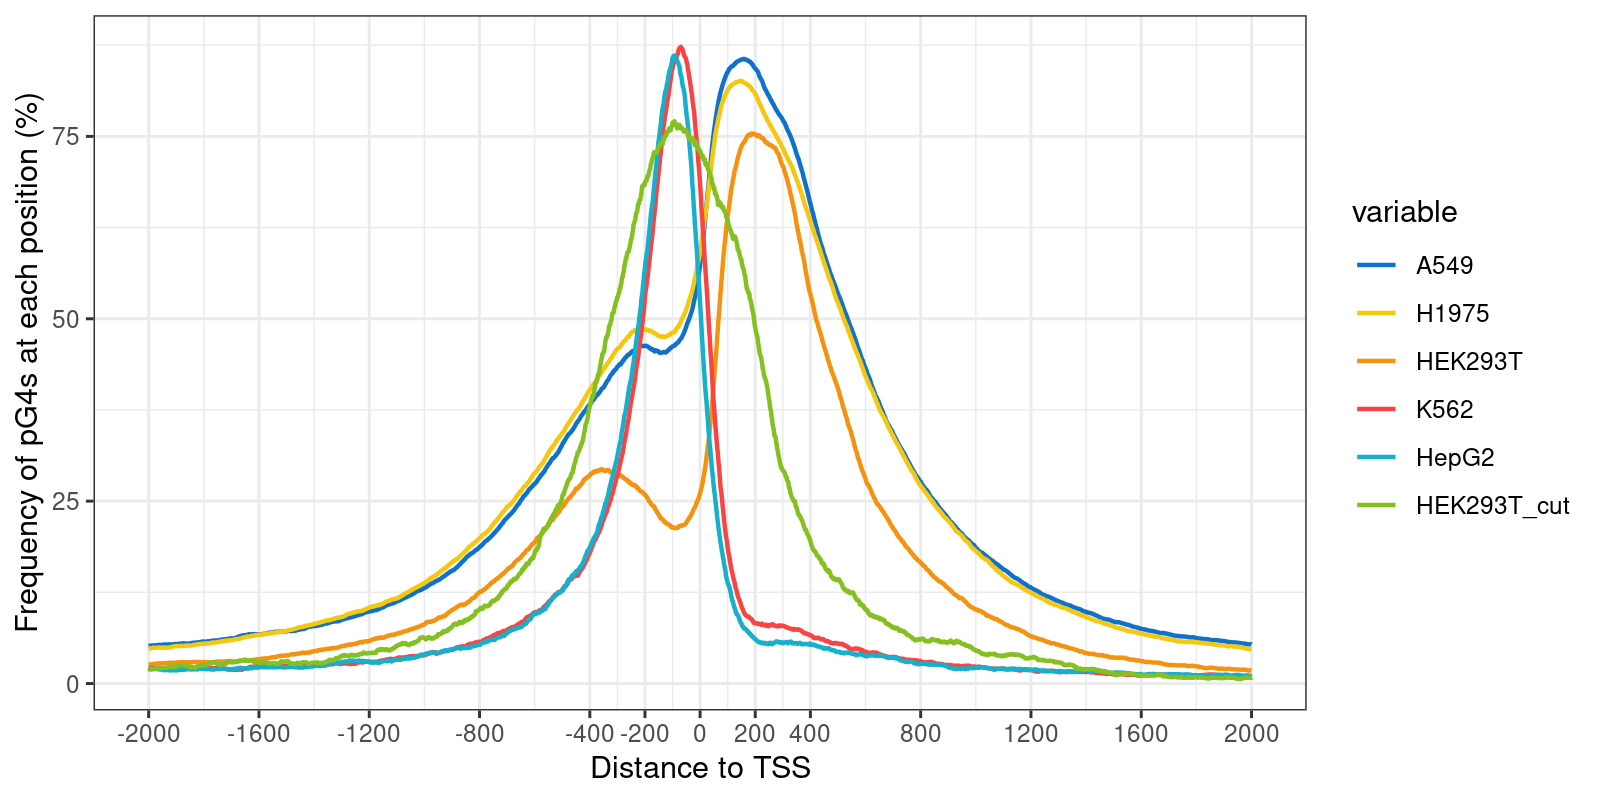

In [11]:
%%R -w 8 -h 4 --units in -r 200
library("ggplot2")
library(grid)
library(gridExtra)
library(dplyr)
library(ggsci)
library(ggsignif)
library(reshape2)
setwd("/disk2/G4_MS/G4_identify/real_chip_seq_G4")

df <- read.csv("realData_posfre.data.csv")
colnames(df) <- c("Distance","A549","H1975","HEK293T", "K562", "HepG2", "HEK293T_cut")
dat <- melt(df,id.vars=c("Distance"))
p1 <- ggplot(data=dat)+geom_line(,mapping=aes(x=Distance,y=value*100,color=variable),size=0.75)+ 
    scale_color_manual(values=c("#0e72cc","77807B","#f59311","#fa4343","#16afcc","#85c021"))

p1 <- p1+labs(x="Distance to TSS",y="Frequency of pG4s at each position (%)")+
    scale_x_continuous(breaks = c(-2000,-1600,-1200,-800,-400,-200,0,200,400,800,1200,1600,2000))+
theme_bw()
grid.arrange(p1)
G <- arrangeGrob(p1)
ggsave("different_celline_real_pos_frequency.pdf",width=8,height=4)

## OQS analysis
### OQs select
### OQs 使用K+ 和 PDS 高通量测序结果 Chambers VS, Marsico G, Boutell JM, Di Antonio M et al. High-throughput sequencing of DNA G-quadruplex structures in the human genome. Nat Biotechnol 2015 Aug;33(8):877-81.

```GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz```

```GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz```
#### transfrom the hg19 genome pos to hg38 using liftover on UCSC

```awk -v OFS="\t" '{if($6=="+"){print $0}}' /disk2/G4_MS/G4_identify/Quadron/hs38d2.quadron.bed|awk '{if($5<100){print $0}}'|bedtools intersect -a - -b GSE63874_Na_K_PDS_minus_hits_intersect.hg38.bed > OQs_hs38d2.quadron.minus.bed```

```awk -v OFS="\t" '{if($6=="-"){print $0}}' /disk2/G4_MS/G4_identify/Quadron/hs38d2.quadron.bed|awk '{if($5<100){print $0}}'|bedtools intersect -a - -b GSE63874_Na_K_PDS_plus_hits_intersect.hg38.bed > OQs_hs38d2.quadron.plus.bed```

```cat OQs_hs38d2.quadron.minus.bed OQs_hs38d2.quadron.plus.bed|sort -k1,1 -k2,2n|uniq > OQs_hs38d2.quadron.bed```

In [ ]:
%% bash
## We defined the pG4s with predicted stability scores of > 19 as stable-pG4, and those with scores ≤ 19 as unstable-pG4
awk -v OFS="\t" '{if($5<100){print $0}}' /disk2/G4_MS/G4_identify/Quadron/hs38d2.quadron.bed|awk '{if($7>19){print $0}}' |sort -k1,1 -k2,2n |uniq > /disk2/G4_MS/G4_identify/Quadron/stable_hs38d2.quadron.bed
awk -v OFS="\t" '{if($5<100){print $0}}' /disk2/G4_MS/G4_identify/Quadron/hs38d2.quadron.bed|awk '{if($7<=19){print $0}}' |sort -k1,1 -k2,2n |uniq > /disk2/G4_MS/G4_identify/Quadron/unstable_hs38d2.quadron.bed

In [ ]:
%%R -w 4 -h 4 --units in -r 200
## supplementary figure 2
library(VennDiagram)
setwd("/disk2/G4_MS/G4_identify/OQs")
rg4 <- read.table("/disk2/G4_MS/G4_identify/OQs/OQs_hs38d2.quadron.bed",header=F)
colnames(rg4) <- c("seqnqme","Start","End","g4","g4_length","Strand","g4_score")
rg4$key <- paste(rg4$seqnqme,rg4$Start, rg4$End,sep="_")
sg4 <- read.table("/disk2/G4_MS/G4_identify/Quadron/stable_hs38d2.quadron.bed",header=F)
colnames(sg4) <- c("seqnqme","Start","End","g4","g4_length","Strand","g4_score")
sg4$key <- paste(sg4$seqnqme,sg4$Start, sg4$End,sep="_")
p <- venn.diagram(x=list(OQs_G4=rg4$key,Stable_G4=sg4$key),height=450,width=450,resolution=300,
                  filename=NULL, col="white",fill=c(colors()[148], colors()[589]), 
                  lwd=1, cat.col="black", cat.pos=c(300, 60), cat.cex=0.45,alpha=c(0.6, 0.6),
                  disable.logging = TRUE,reverse=T)
pdf("OQs_pos_frequency.venn.pdf")
grid.draw(p)
dev.off()

### 1.3 promoter select 
#### 1.3.1 promoter annotion
```
  We difined 1kb upstream of TSS as the promoter (1kb promoter).What's more,activate promoter (0.2kb) is defined as the promoter that was cis-Regulatory Elements which have high DNase and H3K4me3 signals by ENCODE and located 200bp upstream of TSS.
  
  
reference: 
  ENCODE Project Consortium, Jill E. Moore, Michael J. Purcaro, Henry E. Pratt, Charles B. Epstein, Noam Shoresh, Jessika Adrian, et al. 2020. “Expanded Encyclopaedias of DNA Elements in the Human and Mouse Genomes.” Nature 583 (7818): 699–710.

GRCh38-ccREs download url: https://api.wenglab.org/screen_v13/fdownloads/GRCh38-ccREs.PLS.bed
```

#### 1kb promtoer
1kb promoter is defined as 1 kb upstream of TSS, it considers the same promoter;Over 75% overlap of pG4 and promoter is promoter G4.


In [14]:
# prmtr_G4_get_based_TSS.py
import pandas as pd
import pyranges as pr
import os,sys
import logging

def myMkdir(path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)
    return path

def log():
    logger = logging.getLogger("gruns")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger

def pqs_classication(row):
    """
    row from pd.Dataframe 
    """
    if row.Strand == row.Strand_b:
        return "GPQS"
    else:
        return "CPQS"

logger = log()
wd_path = "/disk2/G4_MS/promoter_select"
# wd_path = sys.argv[1]
myMkdir(wd_path)
result_path = myMkdir(os.path.join(wd_path,"promoter_info"))
data_path = os.path.join(wd_path,"data")
gtf_path = "/disk2/G4_MS/reference/gencode.v38.annotation.transcript_basic.gtf"
gtf = pr.read_gtf(gtf_path)
s = gtf.Feature == "transcript"
gtf = gtf[s]
gtf = gtf[gtf.gene_type=="protein_coding"]
gtf = gtf.five_end()
promoter_info = gtf.cluster(slack=25,count=True).assign("Promoter_id",lambda x:"prmtr"+ x.Cluster.astype(str))
promoter_info = promoter_info.slack({"5":1000})
promoter_info = promoter_info.as_df()
promoter_info = promoter_info.loc[:,['Chromosome','Start', 'End', 'Promoter_id', 'gene_id','Strand', 'transcript_id',
                                     'gene_type',"gene_name"]]
promoter_info.to_csv(os.path.join(result_path,"promoter.annotion.tsv"),sep="\t",index=False)
print("gene Numbers: {}".format(len(promoter_info.gene_id.drop_duplicates())))
print("transcript Numbers: {}".format(len(promoter_info.transcript_id.drop_duplicates())))
print("promoter Number: {}".format(len(promoter_info.Promoter_id.drop_duplicates())))
# 
gene_realative_prmtr = promoter_info[["gene_id","Promoter_id"]].drop_duplicates().groupby("gene_id").count()
print("gene_promoter >= 2 Number: {}".format(gene_realative_prmtr[gene_realative_prmtr["Promoter_id"] >=2].shape[0]))

# def overlap_length_count
logger.info("promoter_G4_select....")
g4_path = "/disk2/G4_MS/G4_identify/Quadron"
# g4_path = sys.argv[2]
g4 = pr.PyRanges(pd.read_table(os.path.join(g4_path,"hs38d2.quadron.bed"),header=None,names=['Chromosome', 'Start', 'End', 'Name', 
                                                                                             'G4_length', 'Strand', 'Score']))
promoter = pr.PyRanges(promoter_info)
promoter_nopG4 = promoter.overlap(g4,invert=True)

# g4
g4 = g4[g4.G4_length < 100]
gr = g4.join(promoter,strandedness=False,report_overlap=True)
promoter_pG4 =gr.as_df()
promoter_pG4 = promoter_pG4[promoter_pG4.apply(lambda x:x["Overlap"]/(x["End"]-x["Start"])>0.75,axis=1)]
promoter_pG4["g4_class"] = promoter_pG4.apply(lambda x:pqs_classication(x),axis=1)
promoter_pG4.to_csv(os.path.join(result_path,"promoter_pG4.info.tsv"),sep="\t",index=False)
promoter_nopG4.to_csv(path=os.path.join(result_path,"promoter_nopG4.info.tsv"),sep="\t")
print("promoter pG4s : %s" %promoter_pG4.iloc[:,:7].drop_duplicates().shape[0])
print("promoter GPQS: %s" %promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].iloc[:,:7].drop_duplicates().shape[0])
print("promoter CPQS: %s" %promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].iloc[:,:7].drop_duplicates().shape[0])
print("CPQS & GPQS merged g4 numbers: %s" %promoter_pG4[promoter_pG4["g4_class"] == "GPQS"]
      [promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].apply(lambda x:"|".join(
          [x.Chromosome,str(x.Start),str(x.End)]),axis=1).isin(
          promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].apply(lambda x:"|".join(
              [x.Chromosome,str(x.Start),str(x.End)]),axis=1))].iloc[:,:7].drop_duplicates().shape[0])
print(f"""gene pG4s: {len(set(promoter_pG4.loc[:,"gene_id"]))}""")
print(f"""gene GPQS: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].loc[:,"gene_id"]))}""")
print(f"""gene CPQS: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].loc[:,"gene_id"]))}""")
print(f"""CPQS & GPQS genes: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].loc[:,"gene_id"]
) & set(promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].loc[:,"gene_id"]))}""")

print(f"""promoter pG4s: {len(set(promoter_pG4.loc[:,"Promoter_id"]))}""")
print(f"""promoter GPQS: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].loc[:,"Promoter_id"]))}""")
print(f"""promoter CPQS: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].loc[:,"Promoter_id"]))}""")
print(f"""CPQS & GPQS promoter: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].loc[:,"Promoter_id"]
) & set(promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].loc[:,"Promoter_id"]))}""")

23-03-24 10时17分55秒 gruns INFO promoter_G4_select....


gene Numbers: 19955
transcript Numbers: 61050
promoter Number: 41259
gene_promoter >= 2 Number: 10999
promoter pG4s : 38680
promoter GPQS: 20443
promoter CPQS: 19530
CPQS & GPQS merged g4 numbers: 1293
gene pG4s: 13657
gene GPQS: 10009
gene CPQS: 10008
CPQS & GPQS genes: 6360
promoter pG4s: 24826
promoter GPQS: 17133
promoter CPQS: 17149
CPQS & GPQS promoter: 9456


outputs are **promoter.annotion.tsv, promoter_pG4.info.tsv, promoter_nopG4.info.tsv**

[1] 21.94
[1] 9.303538e-10
[1] 0.4100428 0.7999524
attr(,"conf.level")
[1] 0.95


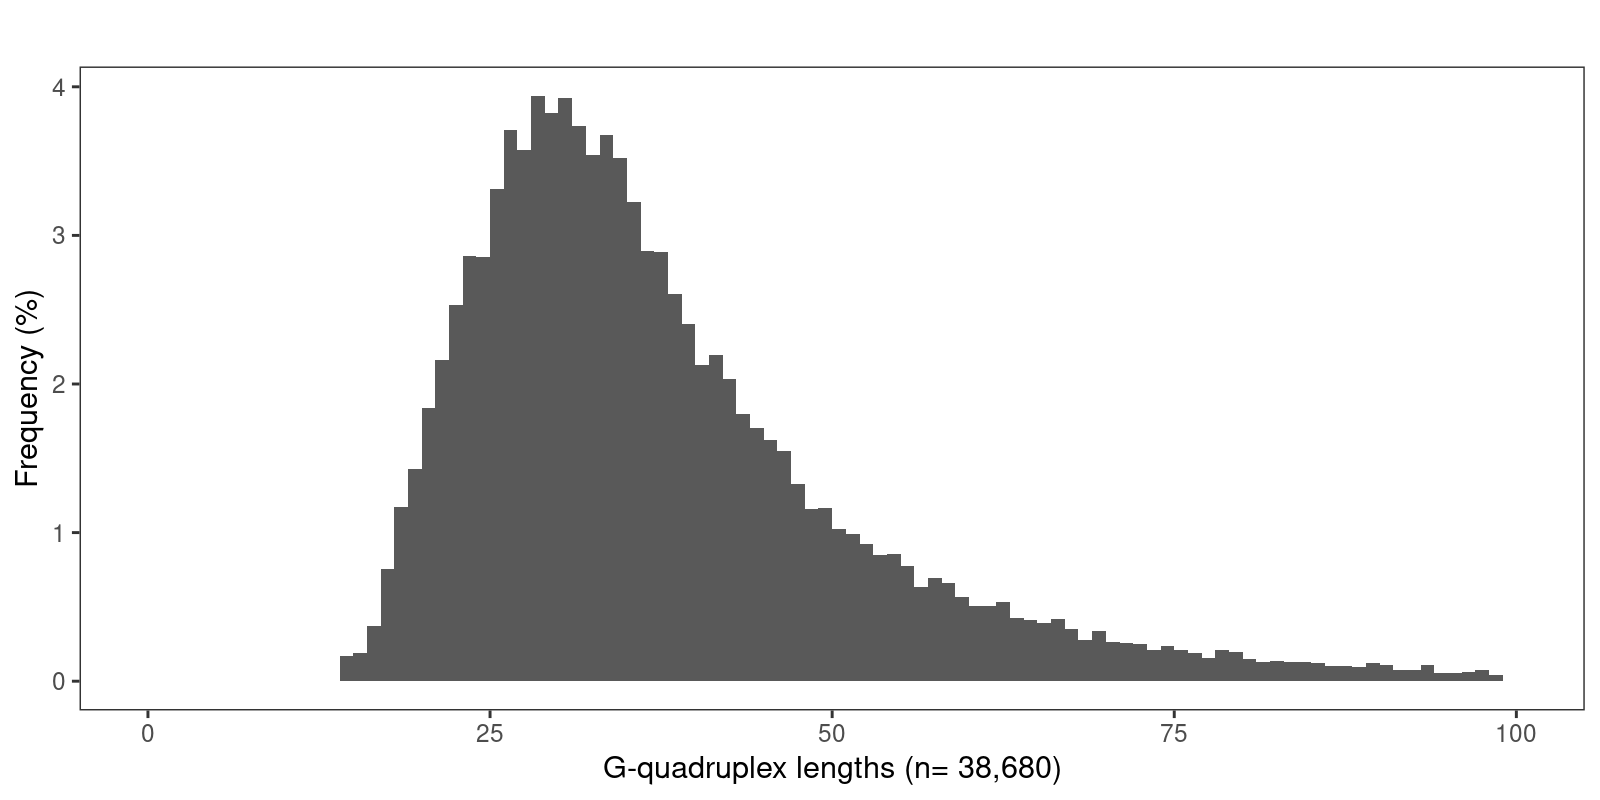

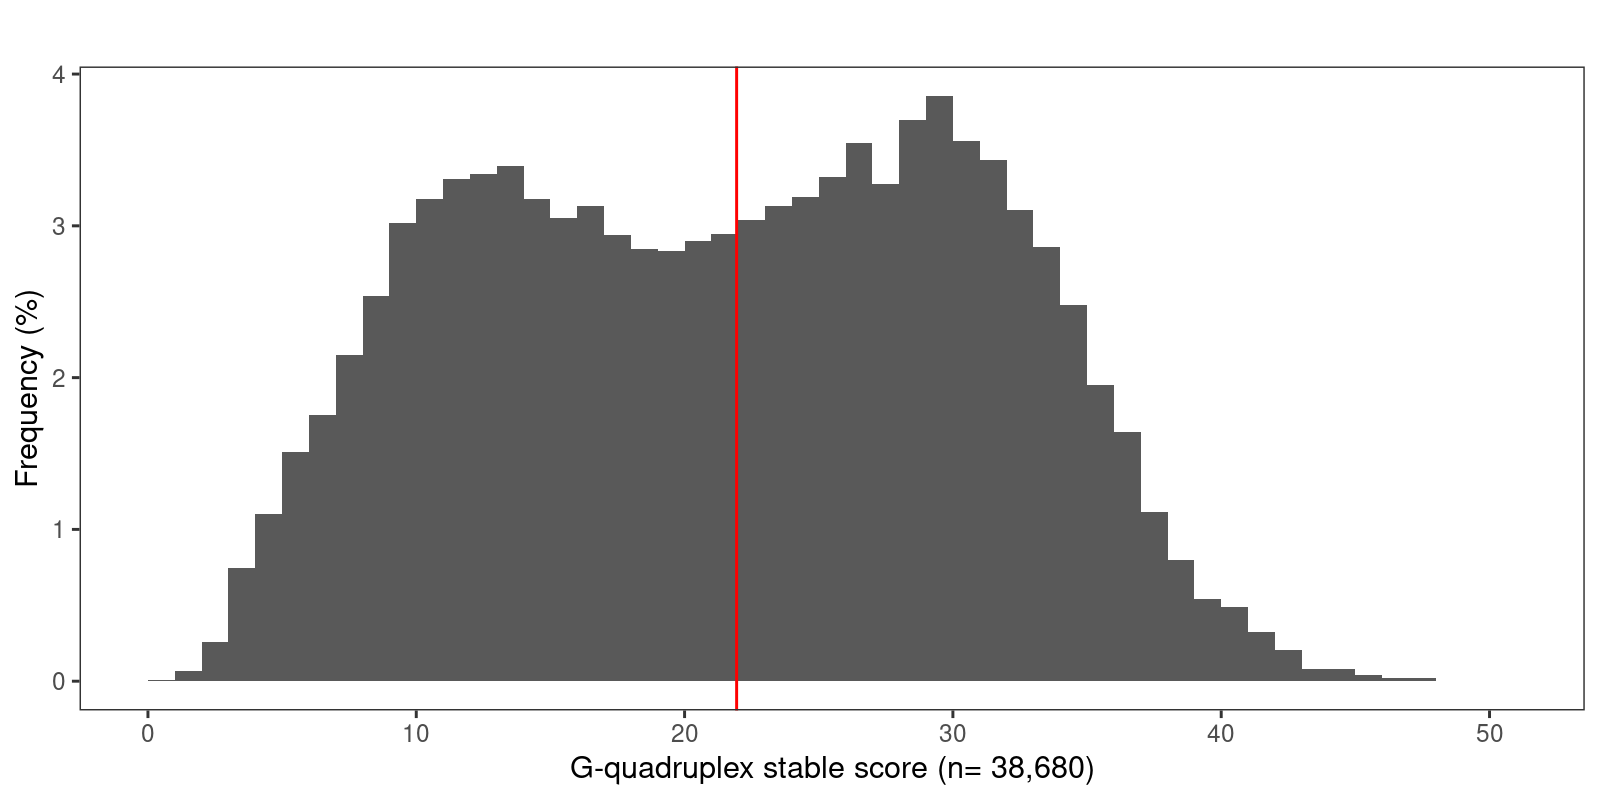

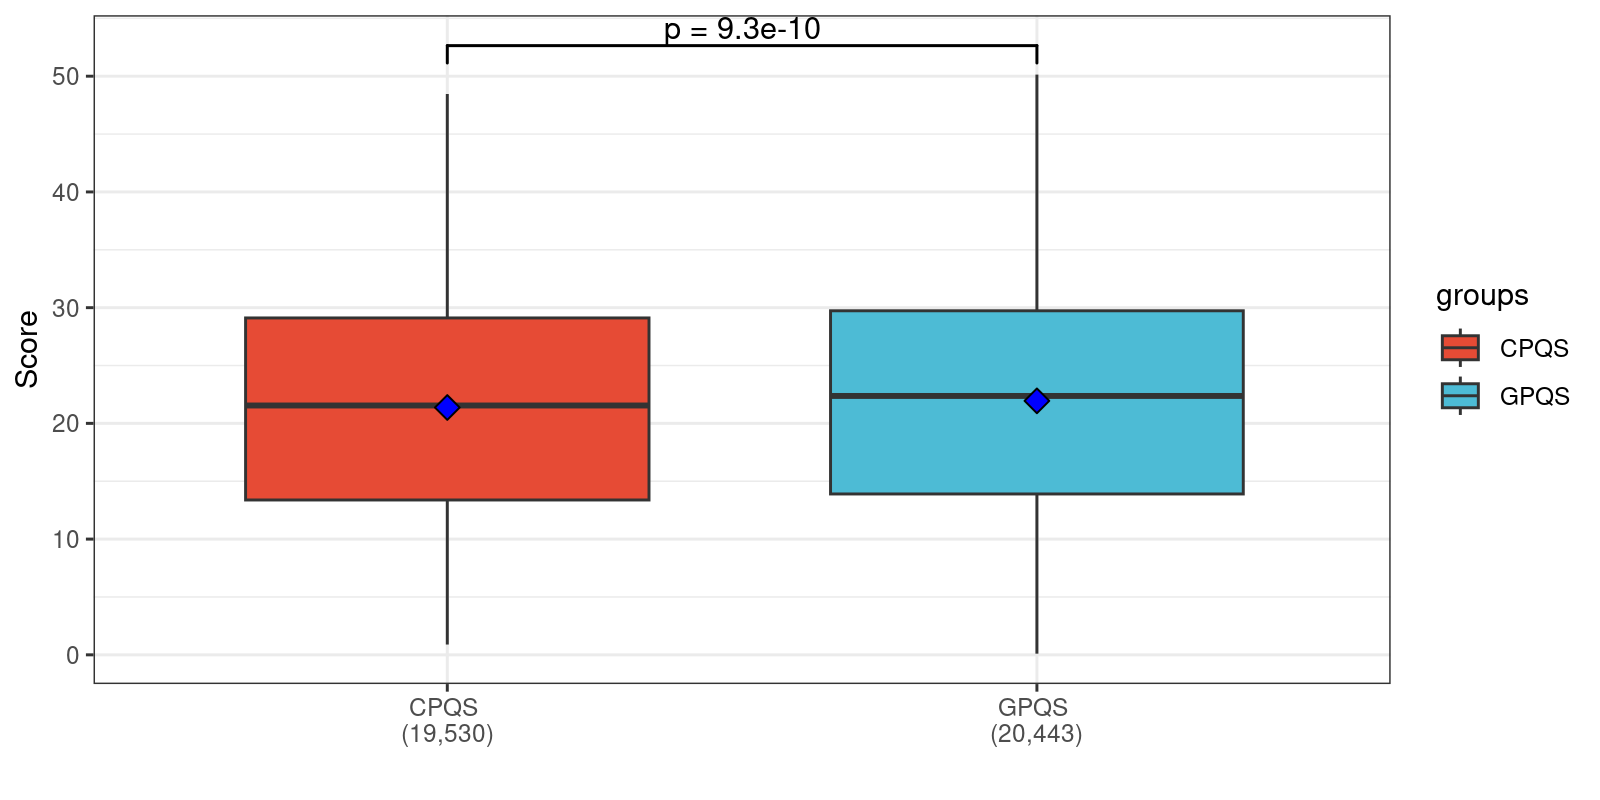

In [15]:
%%R -w 8 -h 4 --units in -r 200
library("ggplot2")
library(grid)
library(gridExtra)
library(dplyr)
library(ggsci)
library(ggsignif)

setwd("/disk2/G4_MS/promoter_select/promoter_info/TSS_promoter")
df <- read.csv("../promoter_pG4.info.tsv",header=T,sep="\t")
gpqs <- df[which(df$g4_class == "GPQS"),][,1:7] %>% distinct()
cpqs <- df[which(df$g4_class == "CPQS"),][,1:7] %>% distinct()
df <- df[,c(1,2,3,4,5,6,7)] %>% distinct()

g1 <- ggplot(data=df,aes(x=G4_length,y=..debsity..))+
    geom_histogram(aes(x=G4_length,y=..density..*100), stat="bin",binwidth=1,boundary=0)+
    xlim(0,100)+labs(title="",
                     y="Frequency (%)",
                     x=paste0("G-quadruplex lengths (","n= ",prettyNum(length(df$G4_length), big.mark=',', trim = TRUE),")"))+
    guides(fill=FALSE) + theme_bw() + theme(panel.grid.major =element_blank(), 
                                            panel.grid.minor = element_blank(),
                                            panel.background = element_blank()) + 
    theme(legend.position="none")
grid.arrange(g1)
G <- arrangeGrob(g1)
ggsave("pG4_tss_promoter.lengths.distribution.pdf",G,width=9,height=5)
print(median(df$Score))
g <- ggplot(data=df,aes(x=Score,y=..debsity..))+
    geom_histogram(aes(x=Score,y=..density..*100), stat="bin",binwidth=1,boundary=0)+
#     xlim(0,60)+
    geom_vline(xintercept=median(df$Score),color="red")+
    labs(title="",y="Frequency (%)",
         x=paste0("G-quadruplex stable score (","n= ",prettyNum(length(df$G4_length), big.mark=',', trim = TRUE),")"))+
    guides(fill=FALSE) + theme_bw() + theme(panel.grid.major =element_blank(), 
                                            panel.grid.minor = element_blank(),
                                            panel.background = element_blank()) + 
    theme(legend.position="none")
grid.arrange(g)
G <- arrangeGrob(g)
ggsave("genomic_G4_stable_score.pdf",G,width=9,height=5)
## stable score compare 
wilcox_test <- wilcox.test(gpqs$Score,cpqs$Score,exact=F,conf.int=T)
print(wilcox_test$p.value)
print(wilcox_test$conf.int)
dat <- data.frame(Score=c(gpqs$Score,cpqs$Score),groups <- c(rep("GPQS",length(gpqs$Score)),rep("CPQS",length(cpqs$Score))))
compared_list <- list(c("CPQS","GPQS"))
g2 <- ggplot(data=dat,aes(x=groups,y=Score))+geom_boxplot(aes(fill=groups),width=0.7,varwidth = TRUE)+scale_fill_npg()+
#     geom_hline(yintercept=median(dat$Score),color="red")+
    scale_x_discrete(breaks=c("CPQS","GPQS"),labels = c(paste0("CPQS \n(",prettyNum(length(cpqs$Score), big.mark=',', trim = TRUE),")"),
                                                        paste0("GPQS \n(",prettyNum(length(gpqs$Score), big.mark=',', trim = TRUE),")")
                                                       ))+
    stat_summary(fun="mean",geom="point",shape=23,size=3,fill="blue") + xlab("")+
    
    geom_signif(comparisons = compared_list, test = wilcox.test, test.args=list(alternative = "two.sided",var.equal=FALSE),
                step_increase = 0,map_signif_level = function(p) sprintf("p = %.3g", p))+
    theme_bw()
grid.arrange(g2)
G <- arrangeGrob(g2)
ggsave("pG4_tss_promoter.pqs_score_compared.pdf",G,width=3,height=4)

#### 0.2kb promoter and promoter G4 annotion

Activate promoter is defined as the promoter that was cis-Regulatory Elements which have high DNase and H3K4me3 signals by ENCODE and located 200bp upstream of TSS.
Over 75% overlap of pG4 and activate promoter is 0.2kb promoter G4.


In [18]:
# prmtr_G4_get_based_H3K4me3.py
import pandas as pd
import pyranges as pr
import os,sys
from collections import Counter
from collections.abc import Iterable
import logging

def myMkdir(path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)
    return path

def log():
    logger = logging.getLogger("promoter_G4")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger

def pqs_classication(row):
    """
    row from pd.Dataframe 
    """
    if row.Strand == row.Strand_b:
        return "GPQS"
    else:
        return "CPQS"
logger = log()
logger.info("script start")
wd_path = "/disk2/G4_MS/promoter_select/promoter_info"
g4path = "/disk2/G4_MS/G4_identify/Quadron"
gtf_path = "/disk2/G4_MS/reference/gencode.v38.annotation.transcript_basic.gtf"
promoter = pr.read_bed(os.path.join(os.path.dirname(wd_path),"data","Promoter_encodeCcreCombined.bed"),)

gtf = pr.read_gtf(gtf_path)
s = gtf.Feature == "transcript" 
gtf = gtf[s]
gtf = gtf[gtf.gene_type=="protein_coding"]
gtf = gtf.five_end()
gr = gtf.k_nearest(promoter,k=10)
gr = gr[(gr.Distance <= 0) & (gr.Distance >= -200)].as_df()
gr = gr.loc[:,['Chromosome', 'Start', 'End', 'Strand', 'gene_id', 'gene_type', 
               'gene_name', 'level','transcript_id', 'transcript_name', 'tag','Start_b', 'End_b', 'Name', 'Distance']]
gr.columns=['Chromosome', 'Start_tss', 'End_tss', 'Strand', 'gene_id', 
           'gene_type', 'gene_name', 'level','transcript_id', 
           'transcript_name', 'tag', 'Start', 'End', 'Promoter_id', 'Distance']
gr = gr[['Chromosome', 'Start', 'End','Promoter_id', 'gene_id',  'Strand','transcript_id',
           'gene_type', 'gene_name', 'Start_tss', 'End_tss']]
gr = pr.PyRanges(gr)
gr = gr.as_df()
gr.to_csv(os.path.join(wd_path,"promoter_info.annotion.H3K4me3.tsv"),sep="\t",index=False)
################
tmp = gr.loc[:,["gene_name",'Promoter_id']].drop_duplicates()
tmpp = tmp.groupby(by="gene_name").count()
print("Gene number: {}".format(gr.gene_id.drop_duplicates().shape[0]))
print("promoter number: {}".format(gr.Promoter_id.drop_duplicates().shape[0]))
print("Contain at least 2 ptomoter gene numbers: {}".format(tmpp[tmpp.Promoter_id >= 2].shape[0]))
# promoter G4 select and noG4 select 
g4_path = "/disk2/G4_MS/G4_identify/Quadron"
g4 = pr.PyRanges(pd.read_table(os.path.join(g4_path,"hs38d2.quadron.bed"),header=None,names=['Chromosome', 'Start', 'End', 
                                                                                             'Name', 'G4_length', 'Strand', 'Score']))
promoter = pr.PyRanges(gr)
promoter_nopG4 = promoter.overlap(g4,invert=True)

g4 = g4[g4.G4_length < 100]
gr = g4.join(promoter,strandedness=False,report_overlap=True)

promoter_pG4 =gr.as_df()
promoter_pG4 = promoter_pG4[promoter_pG4.apply(lambda x:x["Overlap"]/(x["End"]-x["Start"])>0.75,axis=1)]
promoter_pG4["g4_class"] = promoter_pG4.apply(lambda x:pqs_classication(x),axis=1)
promoter_pG4.to_csv(os.path.join(wd_path,"promoter_pG4.info.H3K4me3.tsv"),sep="\t",index=False)
promoter_nopG4.to_csv(path=os.path.join(wd_path,"promoter_nopG4.info.H3K4me3.tsv"),sep="\t")
print("promoter pG4s : %s" %promoter_pG4.iloc[:,:7].drop_duplicates().shape[0])
print("promoter GPQS: %s" %promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].iloc[:,:7].drop_duplicates().shape[0])
print("promoter CPQS: %s" %promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].iloc[:,:7].drop_duplicates().shape[0])
print("CPQS & GPQS merged g4 numbers: %s" %promoter_pG4[promoter_pG4["g4_class"] == "GPQS"]
      [promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].apply(lambda x:"|".join(
          [x.Chromosome,str(x.Start),str(x.End)]),axis=1).isin(
          promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].apply(lambda x:"|".join(
              [x.Chromosome,str(x.Start),str(x.End)]),axis=1))].iloc[:,:7].drop_duplicates().shape[0])
print(f"""gene pG4s: {len(set(promoter_pG4.loc[:,"gene_id"]))}""")
print(f"""gene GPQS: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].loc[:,"gene_id"]))}""")
print(f"""gene CPQS: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].loc[:,"gene_id"]))}""")
print(f"""CPQS & GPQS genes: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].loc[:,"gene_id"]
) & set(promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].loc[:,"gene_id"]))}""")

print(f"""promoter pG4s: {len(set(promoter_pG4.loc[:,"Promoter_id"]))}""")
print(f"""promoter GPQS: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].loc[:,"Promoter_id"]))}""")
print(f"""promoter CPQS: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].loc[:,"Promoter_id"]))}""")
print(f"""CPQS & GPQS promoter: {len(set(promoter_pG4[promoter_pG4["g4_class"] == "CPQS"].loc[:,"Promoter_id"]
) & set(promoter_pG4[promoter_pG4["g4_class"] == "GPQS"].loc[:,"Promoter_id"]))}""")

23-03-24 10时42分40秒 promoter_G4 INFO script start
/usr/software/miniconda3/envs/pyenv/lib/python3.10/site-packages/pyranges/pyranges.py:2594: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not result.__IX__.is_monotonic:


Gene number: 16119
promoter number: 21964
Contain at least 2 ptomoter gene numbers: 5126
promoter pG4s : 16035
promoter GPQS: 8904
promoter CPQS: 7905
CPQS & GPQS merged g4 numbers: 774
gene pG4s: 9510
gene GPQS: 6334
gene CPQS: 5800
CPQS & GPQS genes: 2624
promoter pG4s: 10730
promoter GPQS: 6942
promoter CPQS: 6266
CPQS & GPQS promoter: 2478


output is *** promoter_info.annotion.H3K4me3.tsv, promoter_pG4.info.H3K4me3.tsv, promoter_nopG4.info.H3K4me3.tsv ***

[1] 22.15
[1] 0.0002382644
[1] 0.2399998 0.7800493
attr(,"conf.level")
[1] 0.95


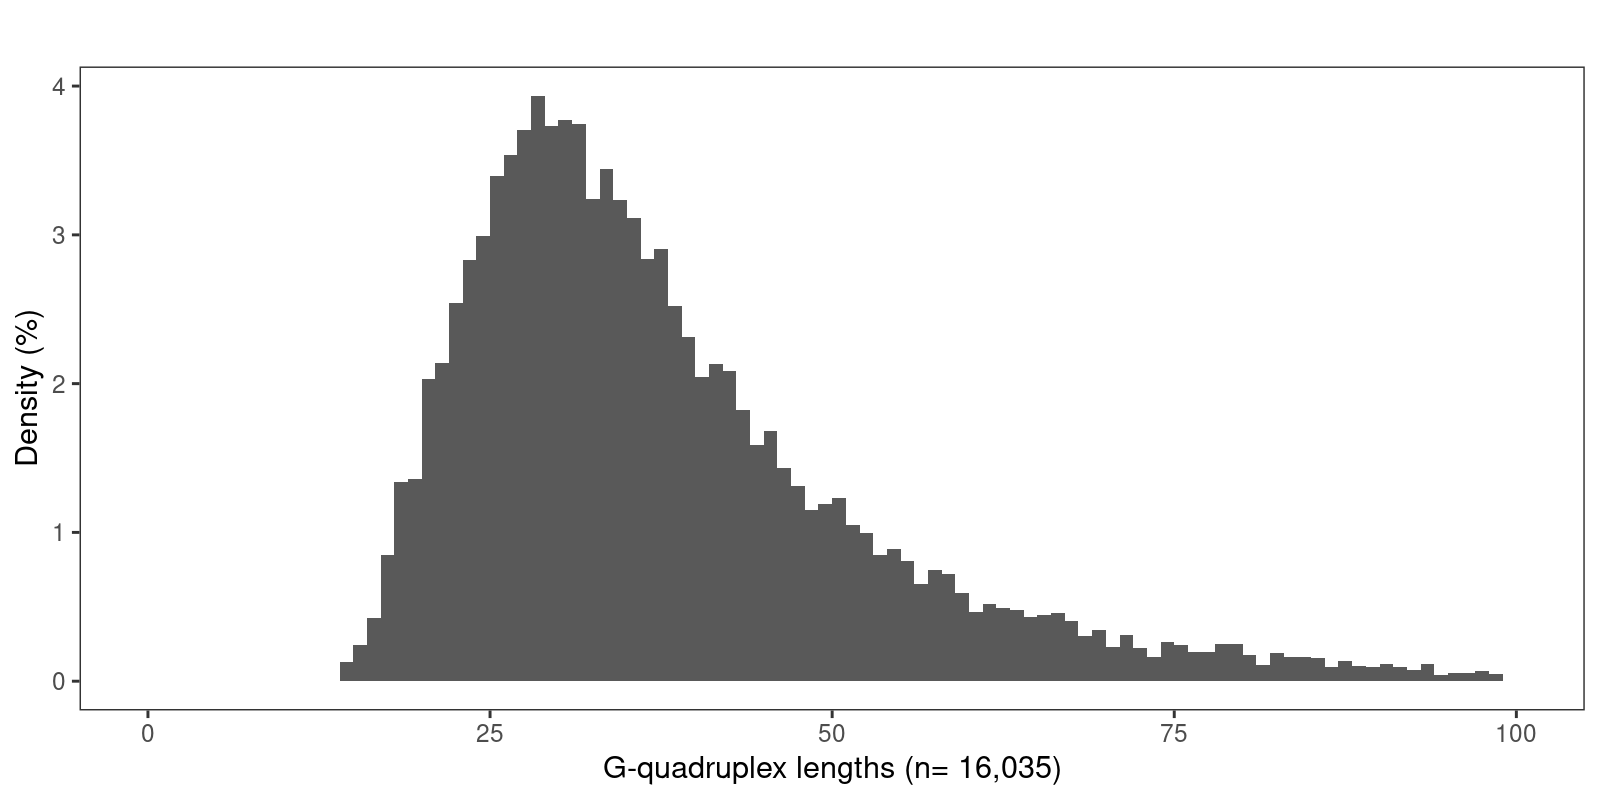

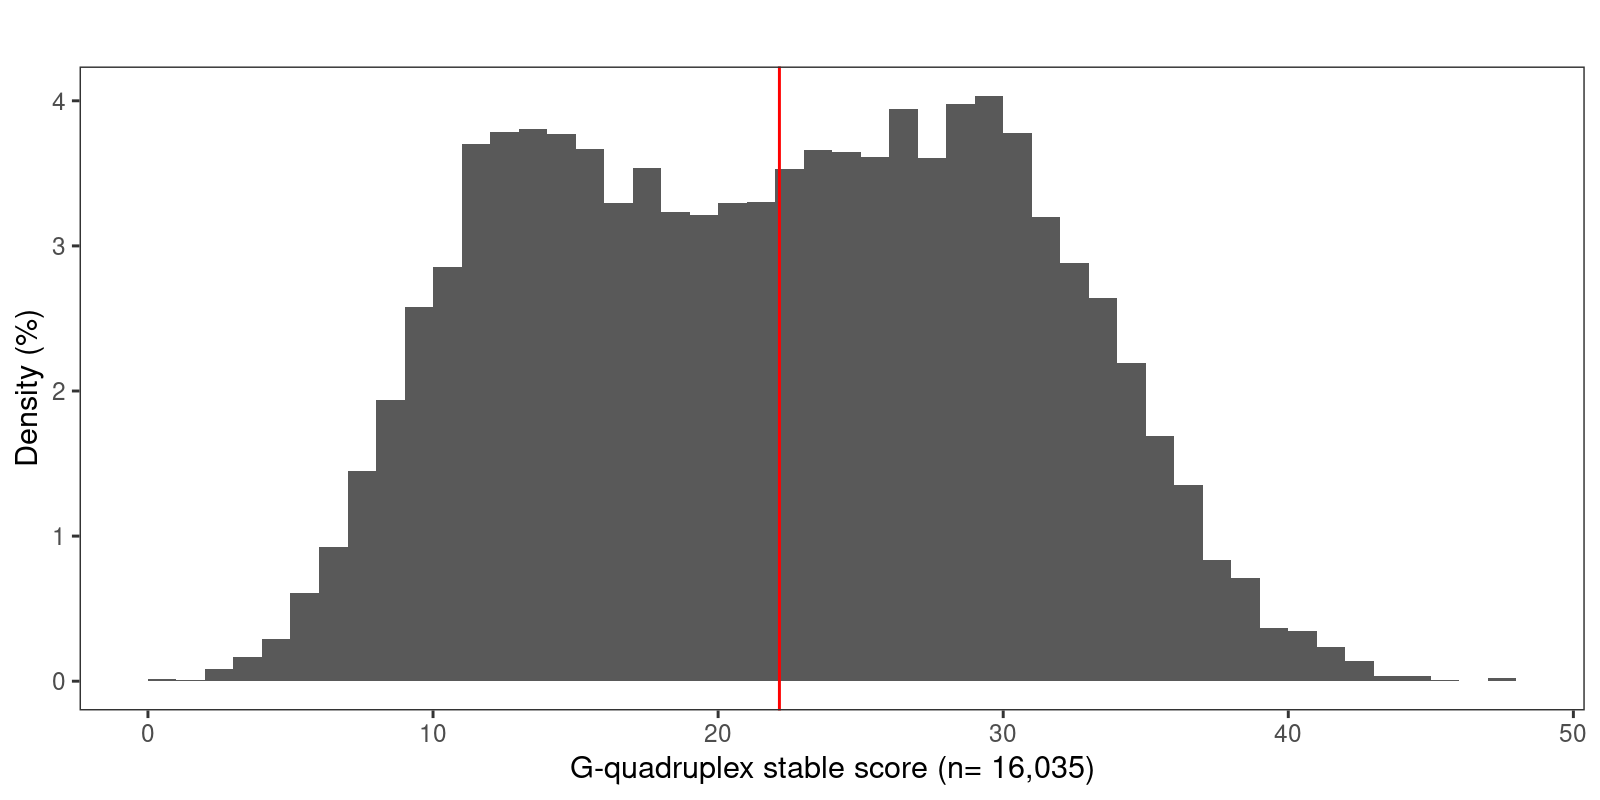

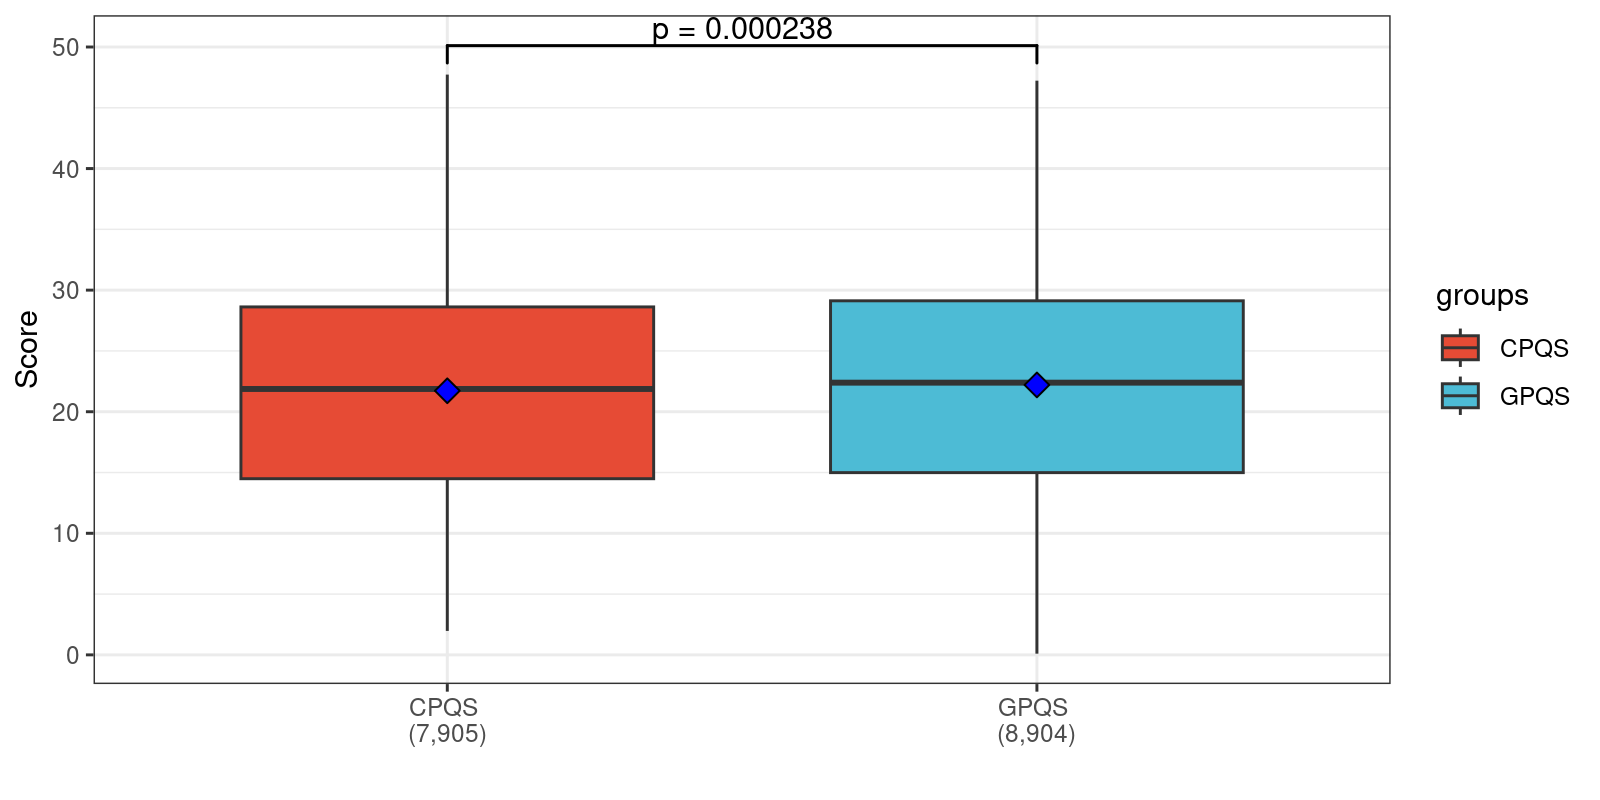

In [19]:
%%R -w 8 -h 4 --units in -r 200
library("ggplot2")
library(grid)
library(gridExtra)
library(dplyr)
library(ggsci)
library(ggsignif)

setwd("/disk2/G4_MS/promoter_select/promoter_info/H3K4me3_promoter")
df <- read.csv("../promoter_pG4.info.H3K4me3.tsv",header=T,sep="\t")
gpqs <- df[which(df$g4_class == "GPQS"),][,1:7] %>% distinct()
cpqs <- df[which(df$g4_class == "CPQS"),][,1:7] %>% distinct()
df <- df[,c(1,2,3,4,5,6,7)] %>% distinct()

g1 <- ggplot(data=df,aes(x=G4_length,y=..debsity..))+
    geom_histogram(aes(x=G4_length,y=..density..*100), stat="bin",binwidth=1,boundary=0)+
    xlim(0,100)+labs(title="",y="Density (%)",
                     x=paste0("G-quadruplex lengths (","n= ",
                              prettyNum(length(df$G4_length), big.mark=',', trim = TRUE),")"))+
    guides(fill=FALSE) + theme_bw() + theme(panel.grid.major =element_blank(), 
                                            panel.grid.minor = element_blank(),
                                            panel.background = element_blank()) + 
    theme(legend.position="none")
grid.arrange(g1)
G <- arrangeGrob(g1)
ggsave("pG4_tss_promoter.lengths.distribution.pdf",G,width=9,height=5)
print(median(df$Score))
g <- ggplot(data=df,aes(x=Score,y=..debsity..))+
    geom_histogram(aes(x=Score,y=..density..*100), stat="bin",binwidth=1,boundary=0)+
#     xlim(0,60)+
    geom_vline(xintercept=median(df$Score),color="red")+
    labs(title="",y="Density (%)",
         x=paste0("G-quadruplex stable score (","n= ",
                  prettyNum(length(df$G4_length), 
                            big.mark=',', trim = TRUE),")"))+
    guides(fill=FALSE) + theme_bw() + theme(panel.grid.major =element_blank(),
                                            panel.grid.minor = element_blank(),
                                            panel.background = element_blank()) + 
    theme(legend.position="none")
grid.arrange(g)
G <- arrangeGrob(g)
ggsave("genomic_G4_stable_score.pdf",G,width=9,height=5)
## stable score compare 
wilcox_test <- wilcox.test(gpqs$Score,cpqs$Score,exact=F,conf.int=T)
print(wilcox_test$p.value)
print(wilcox_test$conf.int)
dat <- data.frame(Score=c(gpqs$Score,cpqs$Score),groups<- c(rep("GPQS",length(gpqs$Score)),rep("CPQS",length(cpqs$Score))))
compared_list <- list(c("CPQS","GPQS"))
g2 <- ggplot(data=dat,aes(x=groups,y=Score))+geom_boxplot(aes(fill=groups),width=0.7)+scale_fill_npg()+
    stat_summary(fun="mean",geom="point",shape=23,size=3,fill="blue") + xlab("")+
    scale_x_discrete(breaks=c("CPQS","GPQS"),labels = c(paste0("CPQS \n(",prettyNum(length(cpqs$Score), big.mark=',', trim = TRUE),")"),
                                                        paste0("GPQS \n(",prettyNum(length(gpqs$Score), big.mark=',', trim = TRUE),")")
                                                       ))+
    geom_signif(comparisons = compared_list, test = wilcox.test, 
                test.args=list(alternative = "two.sided",var.equal=FALSE),
                step_increase = 0,map_signif_level = function(p) sprintf("p = %.3g", p))+
    theme_bw()
grid.arrange(g2)
G <- arrangeGrob(g2)
ggsave("pG4_tss_promoter.pqs_score_compared.pdf",G,width=3,height=4)